# Lab 3
**Joseph Livesey**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal

## Problem 1

The following distribution and "bad data" were taken from the lab assignment.

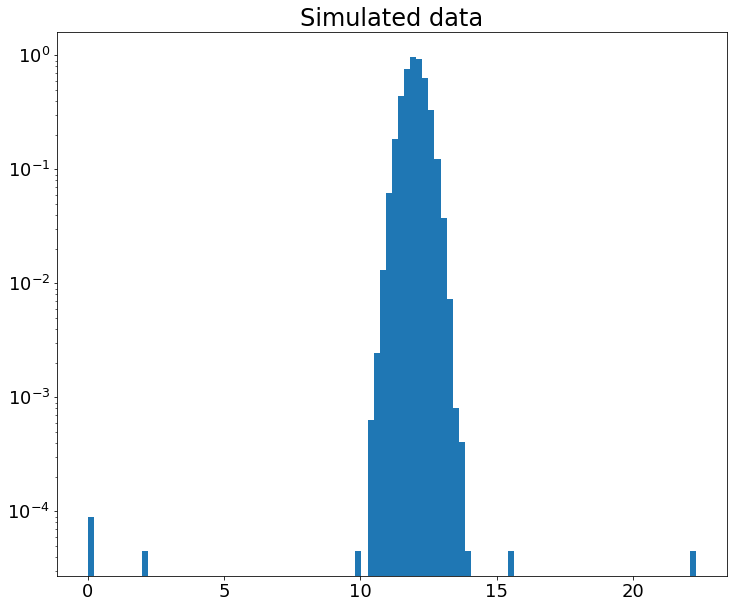

In [28]:
data = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.hist(d, 100, density=True)
ax.set_title('Simulated data', fontsize = 24)
plt.tick_params(labelsize = 18)
plt.yscale('log')
plt.show()

In order to eliminate these points, we can establish some probability threshold that good data may not lie beyond. Our statistical question might therefore be: How many data points have a probability less than $4\sigma$? In math, for how many data points satisfy

$$ \frac{x - \mu}{\sigma} > 4. $$

This gives the corresponding value in the standard normal distribution (sigma value).

In [63]:
def good(x, mean, stdev):
    z = (x - mean)/stdev
    if np.abs(z) <= 4.0:
        return True
    else:
        return False

In [64]:
real_bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]

good_data = []
bad_data = []

false_goods = 0
false_bads = 0
true_goods = 0
true_bads = 0

for d in data:
    if good(d, 12, 0.4) == True:
        good_data.append(d)
        if d in real_bad_data:
            false_goods += 1
        else:
            true_goods += 1
    else:
        bad_data.append(d)
        if d not in real_bad_data:
            false_bads += 1
        else:
            true_bads += 1

true_goods, true_bads, false_goods, false_bads

(99994, 7, 1, 6)

We can thus construct the following truth table.

|  | True good | True bad |
| --- | --- | ---|
| My test good | 99994 | 1 |
| My test bad | 6 | 7 |

If I were to have selected a higher statistical threshold, the number of good data points midjudged as bad ones would have decreased. This is simply because it is less likely to encounter the Gaussian-distributed data at higher sigma values. Only 1 bad data point was misjudged as good. This isn't always avoidable, as bad data can lie close to the mean of the distribution. Bad data can appear anywhere, so these can't necessarily be eliminated in greater proportion by moving the statistical threshold.

## Problem 2

*****Re-state the question from the assignment here.***** In words, we would like to know at what distance corresponds to detection significance, $5\sigma$. In math, we would like to find the distance at which

$$ F(\Delta x, \Delta y) = \varphi(5), $$

where $F(x, y)$ is the cdf of the background and $\varphi(z)$ is the cdf of the standard normal distribution. Of course, in order to find $F(\Delta x, \Delta y)$ we must first write down the pdf of the 2D Gaussian. Because it is radially symmetric, this is straightforward after defining $r^2 = x^2 + y^2$.

$$ f(r) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left ( -\frac{r^2}{2\sigma^2} \right ) \quad \Longrightarrow \quad f(x, y) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left ( -\frac{x^2 + y^2}{2\sigma^2} \right ) $$

The cdf is therefore

$$
F_R(\Delta r) = \int_0^{\Delta x} \int_0^{\Delta y} f_X(x) f_Y(y) \: dy \: dx = \frac{1}{2\pi\sigma^2} \int_0^{\Delta x} \int_0^{\Delta y} \exp \left ( -\frac{x^2 + y^2}{2\sigma^2} \right ) \: dy \: dx = \frac{1}{2\pi\sigma^2} \int_0^{2\pi} \int_0^{\Delta r} r \exp \left ( -\frac{r^2}{2\sigma^2} \right ) \: dr \: d\theta = \frac{1}{\sigma^2} \int_0^{\Delta r} r \exp \left ( -\frac{r^2}{2\sigma^2} \right ) \: dr
$$

From the fundamental theorem of calculus, the pdf of the resulting distribution is just the integrand.

$$ f_R(\Delta r) = \frac{\Delta r}{\sigma^2} \exp \left ( -\frac{\Delta r^2}{2\sigma^2} \right ) $$

This is the pdf of the Rayleigh distribution. Hence, the distances from the mean in our 2D data are Rayleigh distributed. With this knowledge, we employ our usual method for finding the $5\sigma$ value.

In [66]:
r = np.linspace(0, 10, 1000)

for delta_r in r:
    if stats.rayleigh.cdf(delta_r) >= stats.norm.cdf(5.0):
        print(delta_r)
        break

5.495495495495495


The $5\sigma$ distance is $\sim 5.50''$.

## Problem 3

